# Finding frequent itemsets with the Apriori algorithm

In this notebook we will see a simple implementation of the Apriori algorithm using only Python data types (*list, dictionary, tuple*).

We assume that:
- The item identifiers are integers;
- The input file contains a set of baskets, one basket per line;
- each item within a basket is separated by comma ","

An example is:
```text
1,2,3,4
1,2,5
4,6,8,10,22,16
```
Each line contains a basket, each basket contains a set of items!

The other required input is the **support**, expressed as fraction of the total number of baskets (since we do not know how many baskets our dataset will contain).


## Loading the data


We first define the function to load the data -> we can do this because the dataset is small. If teh dataset doesn't fit into the memory, I read the file line by line.

We put each line in a list, so the whole dataset will be a list of lists.

In [235]:
def load_data(filename):
    # Start with empty list
    input_lines = []
    # Read line by line and split (= create a list and put each list as a string element of that list)
    raw_lines = open(filename, 'r').read().splitlines()
    # Then, turn the string into a list
    for line in raw_lines:
        # Take the line, split it and use a comma as a separator -> each element of the list is a string, since it comes from a string,
        # so I transform the elements into integers before putting them in the list
        input_lines.append([int(x) for x in line.split(',')])
        # Now I have a list of lists
    return input_lines

# My datasets is a file made by set of items divided by commas -> I want to transform it into a Python data structure, in this case a LIST.
# Each basket becomes a list and the collection of all of them is put into a bigger List
# The result is a LIST OF LISTS!

# First step: read the file, create a list of which element is a line=string
# Second step: split the line and create from that a list (=set of integers)

The input file containing the dataset is called "1-baskets.txt".

Run the following cell if you are using Colab and you want to mount your google drive as data repository

In [236]:
#from google.colab import drive
#drive.mount('/content/drive')

If you then want to read a file, then call:
```python
input_file = "/content/drive/My Drive/..."
```

Let's load our dataset and print the first 5 lines (baskets)

In [237]:
#input_file = "[PATH]/1-baskets.txt"
input_file = "./1_baskets.txt"

dataset = load_data(input_file)

for elem in dataset[:4]:
    print(elem)
# The dataset is loaded into the RAM now :)

[1, 2, 3, 4, 5, 6, 7, 14]
[1, 2, 8, 12, 14, 15, 19, 20]
[1, 2, 3, 4, 5, 6, 9, 12, 14, 15, 16, 18]
[1, 2, 3, 4, 5, 6, 8, 14, 15, 16, 18]


### Exploratory Analysis
I can do a bit of Exploratory analysis before applying my A-Priori algorithm -> I don't consider a threshold yet!

In [238]:
print(len(dataset))
# Since each element in the list is a basket, the length of the dataset tells me how many baskets I have

39


In [239]:
# How many items do I have? In how many baskets do these items appear?

# Create an empty dictionary
items = {}
for basket in dataset:
    # I consider each item in each basket
    for item in basket:
        # If the identifier of item is already in my dict
        if item in items:
            # Update the dict
            items[item] += 1
        else:
            # Create a new entry in the dict
            items[item] = 1
print("Numbers of distinctive items:", len(items))

Numbers of distinctive items: 20


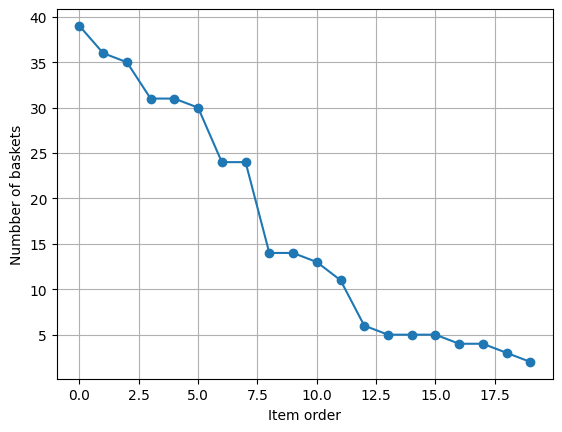

In [240]:
# I create a plot of these results
import matplotlib.pyplot as plt
# I want a descending order, that's why I have the lambda
sorted_items = sorted(items.values(), key = lambda x: -x)
plt.plot(range(len(sorted_items)), sorted_items, "-o")
plt.xlabel("Item order")
plt.ylabel("Numbber of baskets")
plt.grid()
plt.show()
# I created a (normalized) distribution of the frequency of the different items -> it's useful to DEFINE MY THRESHOLD

## First pass

In the first pass, we filter the frequet single items.

We will use a dictionary to keep track of the items and their counts -- this is the complete set of items, called **C1**. We then we filter the dictionary to remove items not sufficently frequent -- in this way we obtain the frequent items **L1**.

In [241]:
# I buil the items and filter out the ones under the threshold
def createL1(dataset, support): #L1 is from the slides, support is the support threshold expressed in %
    # Start with empty dict
    freq_items = {}
    # I build the set of items with the numbers of baskets in which these items appears
    for basket in dataset:
        for item in basket:
            # If the item is in the dict, I update the counter
            if item in freq_items:
                freq_items[item] += 1
            # If the item is not in the dict, I start the counter
            else:
                freq_items[item] = 1

    # HOW TO CORRECTLY DELETE ELEMENTS IN A DICT DUE TO A CONDITION
    # Remove non frequent items -> items that do not appear enough time in the baskets
    support = support * len(dataset)  #len(data) returns the number of baskets
    # In a new structure I keep the keys in which the threshold is not met
    delete = [item for item in freq_items if freq_items[item] < support] # for each item in the frequent items if the value is less than the support, store it in a  list
    # I delete the entries I memorized above
    for item in delete: 
        # Delete elements in the dict
        del freq_items[item]
    
    # Now the dic has only the frequent items
    return freq_items

We are now ready to obtain the frequent items: we show the dictionary (i.e., the count for each item), and then we use only the keys and put them in a list.

In [242]:
support = 0.5 # 50%
freq_item = createL1(dataset, support)
# I print it since the dataset is small
print("The frequent items with their counts are:\n", freq_item)
print("After 15, the elemets appear in less than 24 baskets = below the threshold.")

freq_item_keys = sorted(list(freq_item.keys()))
print("\n\nThe frequent items (L1) are:", freq_item_keys)


The frequent items with their counts are:
 {1: 39, 2: 35, 3: 30, 4: 31, 5: 31, 6: 24, 14: 36, 15: 24}
After 15, the elemets appear in less than 24 baskets = below the threshold.


The frequent items (L1) are: [1, 2, 3, 4, 5, 6, 14, 15]


## Naive algorithm 

Assuming we did not do the first pass, but we would like to find the pairs directly, with a single pass. Let's compute how much memory we need (we will compare the value with the second pass of the Apriori algorithm).

In ordert to count how many times a pair occurs, we use a dictionay, where the key is the pair. Since dictionary keys must be immutable, the pair are represented with a **tuple**. 

In [243]:
import sys  # Used in computing the byte size

# I get the pairs by reading the dataset itself
# Instead of getting rid of non freq. items, every time I read a basket I consider the possibe pairs of the whole baskets
def createL2_naive(dataset, support):
    freq_itemset = {}
    for basket in dataset:
        sorted(basket)
        len_basket = len(basket)
        for i in range(len_basket):
            for j in range(i+1, len_basket):
                pair_tuple = (basket[i],basket[j])
                if pair_tuple in freq_itemset:
                    freq_itemset[pair_tuple] +=1
                else:
                    freq_itemset[pair_tuple] =1
    # At this point, freq_itemset contains all the pairs:
    # This is the maximum space used by this method
    byte_size = sys.getsizeof(freq_itemset) # How big is my datastructure
                    
    # Remove non frequent items
    support = support*len(dataset) 
    delete = [item for item in freq_itemset if freq_itemset[item] < support]
    for item in delete: 
        del freq_itemset[item]
    
    return freq_itemset, byte_size

We can obtain the frequent pairs (we show the dictionary, i.e., the count for each pair), along with the maximum memory used.

In [244]:
freq_pair_naive, naive_size = createL2_naive(dataset, support)
print("The frequent pairs with thier counts are:\n", freq_pair_naive)
print("The memory used with the naive approach is (bytes): ", naive_size)
# It takes up more space

The frequent pairs with thier counts are:
 {(1, 2): 35, (1, 3): 30, (1, 4): 31, (1, 5): 31, (1, 6): 24, (1, 14): 36, (2, 3): 27, (2, 4): 28, (2, 5): 27, (2, 6): 22, (2, 14): 32, (3, 4): 24, (3, 5): 23, (3, 6): 20, (3, 14): 27, (4, 5): 25, (4, 6): 20, (4, 14): 28, (5, 6): 21, (5, 14): 28, (6, 14): 21, (1, 15): 24, (2, 15): 21, (14, 15): 22}
The memory used with the naive approach is (bytes):  9312


## Second pass

With the second pass, for each basket, we first remove non frequent items, then we build all the pairs. In addition to the dataset, we need to pass the L1 list (a list of item idenfitiers, not their counts).

In ordert to count how many times a pair occurs, we use a dictionay, where the key is the pair. Since dictionary keys must be immutable, the pair are represented with a **tuple**. 

With this pass, we directly compute **L2**.

In [245]:
import sys

# I read again the whole dataset
def createL2(dataset, L1, support):
    # An empty dict, now the keys are the pairs and the value is the number of baskets they appear in
    freq_itemset = {}
    for basket in dataset:
        # I consider the potential pairs starting from the FREQUENT items! I remove the non freq. items
        filtered_basket = []
        # Check each item
        for item in basket:
            # Actual check
            if item in L1:
                filtered_basket.append(item)
        # Generate couples
        # I sort my freq items
        sorted(filtered_basket)
        # Check how many elements I have
        len_basket = len(filtered_basket)
        for i in range(len_basket):
            for j in range(i+1, len_basket):
                # The pairs are saved in tuples -> immutable lists
                # They are keys of my dict, so they must be immutable (that's why I use tuple)
                pair_tuple = (filtered_basket[i],filtered_basket[j])
                # Check if tuple is in my dict
                if pair_tuple in freq_itemset:
                    # Update
                    freq_itemset[pair_tuple] +=1
                else:
                    # Create
                    freq_itemset[pair_tuple] =1
    # The freq_itemset contains all the pairs built from freq items
    
    # This is the maximum space used by this method: amount of memory used to count how many possible frequent pairs there are
    byte_size = sys.getsizeof(freq_itemset)
                    
    # Remove non frequent itemset as above!
    support = support*len(dataset) # len(data) returns the number of baskets
    delete = [item for item in freq_itemset if freq_itemset[item] < support]
    for item in delete: 
        del freq_itemset[item]
    
    return freq_itemset, byte_size

We are now ready to obtain the frequent pairs (we show the dictionary, i.e., the count for each pair).

In [246]:
freq_pair, apriori_size = createL2(dataset, freq_item_keys, support)
print("The frequent pairs with thier counts are:\n", freq_pair)

print("The memory used with the apriori approach is (bytes): ", apriori_size)
# It saves space in respect to the Naive approach

The frequent pairs with thier counts are:
 {(1, 2): 35, (1, 3): 30, (1, 4): 31, (1, 5): 31, (1, 6): 24, (1, 14): 36, (2, 3): 27, (2, 4): 28, (2, 5): 27, (2, 6): 22, (2, 14): 32, (3, 4): 24, (3, 5): 23, (3, 6): 20, (3, 14): 27, (4, 5): 25, (4, 6): 20, (4, 14): 28, (5, 6): 21, (5, 14): 28, (6, 14): 21, (1, 15): 24, (2, 15): 21, (14, 15): 22}
The memory used with the apriori approach is (bytes):  1176


## Third pass

Now it is possible to find the triples, which is left as exercise.

Triples (**C3**) can be build starting, as input, from L1 and L2 (only the keys, not the whole dictionary).

```python
def createL3(dataset, L2, L1, support):
    freq_itemset = {}
    for basket in dataset:
        # remove non freq. items
        filtered_basket = []
        for item in basket:
            if item in L1:
                filtered_basket.append(item)
        # generate triples, but only if the 
        # possible couples are frequent 
        ...         
    # remove non frequent itemset; 
    ...
    return freq_itemset
```

### Question  Q1
<div class="alert alert-info">
Using the skeleton provided above, implement the function createL3( )
</div>

In [247]:
def createL3(dataset, L2, L1, support):
    # Dict
    freq_trips = {}
    for basket in dataset:
        # Filet non freq. items
        filtered_basket = []
        for item in basket:
            if item in L1:
                filtered_basket.append(item)
        sorted(filtered_basket)
        len_basket = len(filtered_basket)
        # Filter non freq. pairs
        filtered_basket_pairs = []
        for i in range(len_basket):
            for j in range(i+1, len_basket):
                pair_tuple = (filtered_basket[i], filtered_basket[j])
                if pair_tuple in L2:
                    filtered_basket_pairs.append(pair_tuple)
        sorted(filtered_basket_pairs)
        len_basket_pairs = len(filtered_basket_pairs)
        # Generate triplets
        for i in range(len_basket_pairs):
            for j in range(len_basket):
                    trip_tuple = (filtered_basket_pairs[i], filtered_basket[j])
                    if trip_tuple in freq_trips:
                        freq_trips[trip_tuple] += 1
                    else:
                        freq_trips[trip_tuple] = 1

    support = support * len(dataset) # len(data) returns the number of baskets
    delete_pairs = [pair for pair in freq_trips if freq_trips[pair] < support]
    for pair in delete_pairs: 
        del freq_trips[pair]

    return freq_trips

In [248]:
freq_pair_keys = sorted(list(freq_pair.keys()))

freq_trip = createL3(dataset, freq_pair_keys, freq_item_keys, support)
print("The frequent pairs with thier counts are:\n", freq_trip)

The frequent pairs with thier counts are:
 {((1, 2), 1): 35, ((1, 2), 2): 35, ((1, 2), 3): 27, ((1, 2), 4): 28, ((1, 2), 5): 27, ((1, 2), 6): 22, ((1, 2), 14): 32, ((1, 3), 1): 30, ((1, 3), 2): 27, ((1, 3), 3): 30, ((1, 3), 4): 24, ((1, 3), 5): 23, ((1, 3), 6): 20, ((1, 3), 14): 27, ((1, 4), 1): 31, ((1, 4), 2): 28, ((1, 4), 3): 24, ((1, 4), 4): 31, ((1, 4), 5): 25, ((1, 4), 6): 20, ((1, 4), 14): 28, ((1, 5), 1): 31, ((1, 5), 2): 27, ((1, 5), 3): 23, ((1, 5), 4): 25, ((1, 5), 5): 31, ((1, 5), 6): 21, ((1, 5), 14): 28, ((1, 6), 1): 24, ((1, 6), 2): 22, ((1, 6), 3): 20, ((1, 6), 4): 20, ((1, 6), 5): 21, ((1, 6), 6): 24, ((1, 6), 14): 21, ((1, 14), 1): 36, ((1, 14), 2): 32, ((1, 14), 3): 27, ((1, 14), 4): 28, ((1, 14), 5): 28, ((1, 14), 6): 21, ((1, 14), 14): 36, ((2, 3), 1): 27, ((2, 3), 2): 27, ((2, 3), 3): 27, ((2, 3), 4): 22, ((2, 3), 5): 20, ((2, 3), 14): 24, ((2, 4), 1): 28, ((2, 4), 2): 28, ((2, 4), 3): 22, ((2, 4), 4): 28, ((2, 4), 5): 22, ((2, 4), 14): 25, ((2, 5), 1): 27, ((2, 5

### Question  Q2
<div class="alert alert-info">
Find the triples and the amount of memory used to compute such a result
</div>

In [249]:
import sys

def createL3(dataset, L2, L1, support):
    # Dict
    freq_trips = {}
    for basket in dataset:
        # Filet non freq. items
        filtered_basket = []
        for item in basket:
            if item in L1:
                filtered_basket.append(item)
        sorted(filtered_basket)
        len_basket = len(filtered_basket)
        # Filter non freq. pairs
        filtered_basket_pairs = []
        for i in range(len_basket):
            for j in range(i+1, len_basket):
                pair_tuple = (filtered_basket[i], filtered_basket[j])
                if pair_tuple in L2:
                    filtered_basket_pairs.append(pair_tuple)
        sorted(filtered_basket_pairs)
        len_basket_pairs = len(filtered_basket_pairs)
        # Generate triplets
        for i in range(len_basket_pairs):
            for j in range(len_basket):
                    trip_tuple = (filtered_basket_pairs[i], filtered_basket[j])
                    if trip_tuple in freq_trips:
                        freq_trips[trip_tuple] += 1
                    else:
                        freq_trips[trip_tuple] = 1

    # This is the maximum space used by this method: amount of memory used to count how many possible frequent pairs there are
    byte_size = sys.getsizeof(freq_trips)

    support = support * len(dataset) # len(data) returns the number of baskets
    delete_pairs = [pair for pair in freq_trips if freq_trips[pair] < support]
    for pair in delete_pairs: 
        del freq_trips[pair]
    return byte_size

In [250]:
apriori_size = createL3(dataset, freq_pair_keys, freq_item_keys, support)
print("The memory used with the apriori approach is (bytes): ", apriori_size)

The memory used with the apriori approach is (bytes):  9312
